# Classifying newswires based on topics

Training neural network to perform single label multiclass classification on reuters newswire dataset

In [89]:
from keras.datasets import reuters
from keras import models
from keras import layers
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np

## The Reuters dataset

Downloading reuters dataset with on only the top 10000 most frequent words

In [71]:
(train_dataset, train_label), (test_dataset, test_label) = reuters.load_data(num_words = 10000)

The dataset is divided into 8982 samples for training and 2246 for testing

In [72]:
print(train_dataset.shape)
print(test_dataset.shape)

(8982,)
(2246,)


In [101]:
print(train_dataset[0], '\n')
print(train_label[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12] 

3


The provided train_data and test_data is in the format of word indices from a specific word in a dictionary.

The provided train_label and test_label are integers which represent which class the corresponding data belongs to.

## Decode sentences

Lets define a function to decode these vectors of indices back into english sentences

In [74]:
# i - 3 because the first three indices are reserved for padding, start of sequence, and unknown
def decode(index):
    word_dict = reuters.get_word_index()
    reversed_word_dict = dict([(value, key) for (key, value) in word_dict.items()])
    result = ' '.join([reversed_word_dict.get(i - 3, '?') for i in train_dataset[index]])
    return result

In [75]:
decode(0)

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

In [76]:
decode(1)

'? generale de banque sa lt ? br and lt heller overseas corp of chicago have each taken 50 pct stakes in ? company sa ? factors generale de banque said in a statement it gave no financial details of the transaction sa ? ? turnover in 1986 was 17 5 billion belgian francs reuter 3'

## Preparing the dataset

Inorder to feed this dataset into a neural network, we have to preprocess the data into an appropriate and consistent format 

### Encoding the train and test data into 10000 dimensional vectors

In [77]:
def one_hot_encode(data, dimensions = 10000):
    results = np.zeros((len(data), dimensions))
    for i, seq in enumerate(data):
        results[i,seq] = 1
    return results

In [78]:
x_train = one_hot_encode(train_dataset)
x_test = one_hot_encode(test_dataset)

## Encoding labels

We will use the keras utility function

In [83]:
one_hot_train_labels = to_categorical(train_label)
one_hot_test_labels = to_categorical(test_label)

In [84]:
one_hot_train_labels.shape

(8982, 46)

This is good because there are 8982 samples and 46 different classes, now we need to create a validation set inorder to tweak hyperparameter values

## Validation set

We will create a split our training samples into training and validations sets

In [96]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

## Model definition

If you checked out my binary classification model on the imdb dataset, I chose to use only intermediate layers of 16. However, for this multiclass problem, that might be too shallow to classify 46 individual classes. Thus we will use 64 neurons in the intermediate layer and analyze for further tweaks.

We will define our model as follows:
    - two intermediate layers of 64 neurons each with the activation function of relu
    - a single output layer of 46 neurons (one for each class) with the activation function of softmax to output a probability distribution over the 46 different output classes

In [118]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape = (10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

### Hyperparameters

We will test out rmsprop optimizer with the default learning rate

Also, the loss function will be categorical_crossentropy to measure the distance between two probability distributions while keeping track of the accuracy

In [119]:
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])

## Training the Model

Running the model on 20 epochs, with batch sizes of 128

In [120]:
history = model.fit(partial_x_train,partial_y_train, epochs = 20, batch_size = 512, validation_data = (x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 228us/step - loss: 2.7927 - acc: 0.5080 - val_loss: 1.8428 - val_acc: 0.6360
Epoch 2/20
7982/7982 [==============================] - 1s 186us/step - loss: 1.4908 - acc: 0.7097 - val_loss: 1.3312 - val_acc: 0.7270
Epoch 3/20
7982/7982 [==============================] - 2s 200us/step - loss: 1.0725 - acc: 0.7707 - val_loss: 1.1375 - val_acc: 0.7600
Epoch 4/20
7982/7982 [==============================] - 2s 204us/step - loss: 0.8359 - acc: 0.8270 - val_loss: 1.0372 - val_acc: 0.7940
Epoch 5/20
7982/7982 [==============================] - 1s 186us/step - loss: 0.6664 - acc: 0.8626 - val_loss: 0.9730 - val_acc: 0.7980
Epoch 6/20
7982/7982 [==============================] - 2s 206us/step - loss: 0.5324 - acc: 0.8899 - val_loss: 0.9470 - val_acc: 0.8050
Epoch 7/20
7982/7982 [==============================] - 2s 203us/step - loss: 0.4298 - acc: 0.9113 - val_loss: 0.9169 - val_acc: 0.8160


## Analysis

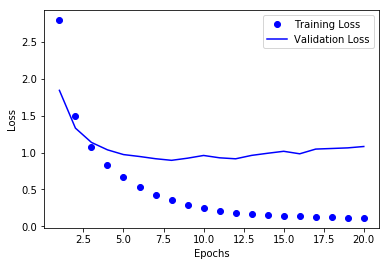

In [121]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

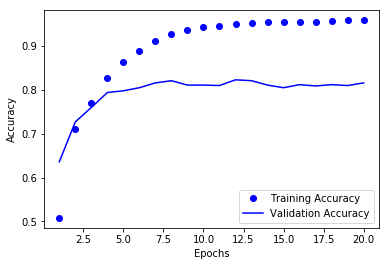

In [124]:
train_acc = history.history['acc']
val_acc = history.history['val_acc']

plt.clf()
plt.plot(epochs, train_acc, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Summary

It seems like the model had the best accuracy and loss around 8 epochs.

After 8 epochs, the model started to overfit to the training data.

Lets rebuild the model to use the entire training set and train it on 8 epochs

## Rebuild the model and evaluate on the test dataset

In [130]:
model_final = models.Sequential()
model_final.add(layers.Dense(64, activation = 'relu', input_shape = (10000,)))
model_final.add(layers.Dense(64, activation = 'relu'))
model_final.add(layers.Dense(46, activation = 'softmax'))
model_final.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
model_final.fit(x_train, one_hot_train_labels, epochs = 9, batch_size = 512)

Epoch 1/9
8982/8982 [==============================] - 2s 224us/step - loss: 2.5356 - acc: 0.5537
Epoch 2/9
8982/8982 [==============================] - 1s 162us/step - loss: 1.3253 - acc: 0.7246
Epoch 3/9
8982/8982 [==============================] - 1s 160us/step - loss: 0.9800 - acc: 0.7897
Epoch 4/9
8982/8982 [==============================] - 1s 160us/step - loss: 0.7659 - acc: 0.8385
Epoch 5/9
8982/8982 [==============================] - 1s 167us/step - loss: 0.6086 - acc: 0.8707
Epoch 6/9
8982/8982 [==============================] - 2s 174us/step - loss: 0.4857 - acc: 0.9005
Epoch 7/9
8982/8982 [==============================] - 2s 181us/step - loss: 0.3916 - acc: 0.9187
Epoch 8/9
8982/8982 [==============================] - 2s 176us/step - loss: 0.3200 - acc: 0.9316
Epoch 9/9
8982/8982 [==============================] - 2s 177us/step - loss: 0.2691 - acc: 0.9413


In [131]:
results = model_final.evaluate(x_test, one_hot_test_labels)

2246/2246 [==============================] - 1s 241us/step


In [132]:
results

[0.9561034473901546, 0.794746215494212]

The accuracy of the model is at ~80%

## Comparison with a less intermediate neuron neural network

Lets create a 4 intermediate neuron neural network and compare the results

In [147]:
model_32 = models.Sequential()
model_32.add(layers.Dense(64, activation = 'relu', input_shape = (10000,)))
model_32.add(layers.Dense(4, activation ='relu'))
model_32.add(layers.Dense(46, activation = 'softmax'))
model_32.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
model_32.fit(x_train, one_hot_train_labels, epochs = 9, batch_size = 512)

Epoch 1/9
8982/8982 [==============================] - 3s 379us/step - loss: 3.5554 - acc: 0.3460
Epoch 2/9
8982/8982 [==============================] - 2s 245us/step - loss: 2.9371 - acc: 0.4531
Epoch 3/9
8982/8982 [==============================] - 2s 246us/step - loss: 2.5307 - acc: 0.4801
Epoch 4/9
8982/8982 [==============================] - 2s 248us/step - loss: 2.2938 - acc: 0.5122
Epoch 5/9
8982/8982 [==============================] - 2s 242us/step - loss: 2.1332 - acc: 0.5381
Epoch 6/9
8982/8982 [==============================] - 2s 242us/step - loss: 2.0098 - acc: 0.5376
Epoch 7/9
8982/8982 [==============================] - 2s 251us/step - loss: 1.9009 - acc: 0.5331
Epoch 8/9
8982/8982 [==============================] - 2s 246us/step - loss: 1.7999 - acc: 0.5245
Epoch 9/9
8982/8982 [==============================] - 2s 249us/step - loss: 1.7074 - acc: 0.5296


In [148]:
results = model_32.evaluate(x_test, one_hot_test_labels)

2246/2246 [==============================] - 1s 408us/step


In [149]:
results

[2.021742804604562, 0.4897595726265402]

The accuracy of the model is significantly lower at ~48%, this is due to the bottle necking of information in the itermediate layer, the data loss in this layer are gone forever, since each layer is only recieving information from the previous layer

# Conclusion

In conclusion, training at 9 epochs was good and achieved an accuracy of ~80%. The choice of the intermediate number of neurons was also good since too little neurons would bottle neck it while too many neurons would cause the model to overfit to the training data